### Polarizability of a Rayleigh scatterer with electric double layer

- Main author: Sanli Faez, 
- First version: 26 October 2018
- Second version: 26 December 2018, enhancing plots for the manuscript, included Stern layer

This code calculates the total polarizability a nanometric Rayleigh scatterer considering the changes in the refractice index of the surrounding medium because of the electrolyte concentration.

For refractive indeices we use the values provided by An et al. (DOI: 10.1021/acs.jpcb.5b05433) and assume that the contribution of ion and counterion to index change is proportional to their polarizability in the gas phase.

To summarize: $$n_{mix} = n_{sol} + K \frac{x_{ion}\alpha_{ion} + x_{cou}\alpha_{cou}}{\alpha_{ion}+\alpha_{cou}},$$
where $x_a$ is the number density of the solute of type $a$ relatie to the solvent number density.

For the NaCl example: K = 0.479, $\alpha_{Na}= 0.179$ and $\alpha_{Cl}= 3.66$. Unit of polarizability is angstrom cube in cgs units. 

For potentials higher than $k_B T/e = 25 meV$ we should also consider the formation of the Stern layer that regulates the potential. The density of the counter charge in the Stern layer is given by 
$$ x_S = \frac{(V - \zeta)e}{4 \pi k_B T \lambda_B d_S a} $$,

where $\lambda_B, d_S$ are the Bjerrum length and the Stern layer thickness, respectively. $a$ is the particle radius.


In [2]:
#import necessary modules
import matplotlib.pyplot as plt
import numpy as np

### 1- Density and index distribution 

<function matplotlib.pyplot.show>

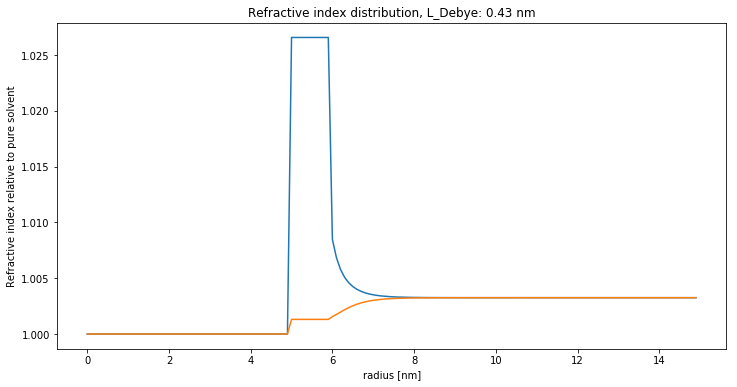

In [9]:
# defining quantities and their values
salt_concentration = 0.5 # ionic strength in molar
debye_length = 0.304/np.sqrt(salt_concentration) #debye length [nm] in water at 25 C 
particle_radius = 5 #particle diameter in nm

def n_mix_NaCl(r, salinity, surfpot, zeta, p_radius, d_stern, dr = 0.1, n_sol = 1.33, lb = 0.7):
    """
    function provides refractive index (RI) as a function of distance *outside* the particle
    
    input
    
    salinity: salt concentration in molar
    surfpot: applied surface potential in units of kT/e
    zeta: zeta potential in kT/e
    p_radius: particle radius in nm
    d_stern: thinkness of the Stern layer in nm
    raxis: positions to calculate RI
    dr: diferential of radius in nanometer
    n_sol: refractive index of the solvent
    lb: Bjerrum length in nm
    
    returns 
    n: refractive index of the salt solution normalized to the solvent RI
    
    """
    x_salt = salinity / 55.36 #number density fraction in water assuming a monovalent salt
    a_ion = 0.18 #gas phase polarizability for Na
    a_cou = 3.66 #gas phase polarizability for Cl
    K_salt = 0.479
    ldebye = 0.304/np.sqrt(salinity) #debye length [nm] in water at 25 C 
    i_obj = np.int((p_radius)/dr)
    r_dif = p_radius+d_stern
    i_dif = np.int(r_dif/dr)


    #using Debye-Huckel theorem in the thin EDL regime
    psi = 0*r
    psi[i_dif:] = zeta * r_dif / r[i_dif:] * np.exp(-(r[i_dif:]-r_dif)/ldebye)
    x_ion = 0*r
    x_cou = 0*r
    x_ion[i_dif:] = x_salt * np.exp(-psi[i_dif:])
    x_cou[i_dif:] = x_salt * np.exp(psi[i_dif:])

    #assuming a homogeneous concentration of only counter-ion in the stern layer
    if surfpot > zeta:
        x_s = (surfpot - zeta) / (33.21 * lb * p_radius * d_stern)
        x_cou[i_obj:i_dif] = x_s * np.ones(i_dif - i_obj)
    elif surfpot < zeta:
        x_s = -(surfpot - zeta) / (33.21 * lb * p_radius * d_stern)
        x_ion[i_obj:i_dif] = x_s * np.ones(i_dif - i_obj)
            
    n = 0*r
    n = 1 + K_salt / n_sol * (a_ion * x_ion + a_cou * x_cou) / (a_ion + a_cou) 
    
    ## Block for plotting the concentration 
    # plt.plot(r, x_ion)
    # plt.plot(r, x_cou)
    # plt.title("Ion density distribution in the EDL, Salinity: %4.2f Molar"%salinity )
    # plt.ylabel("particle density")
    # plt.xlabel("radius [nm]")
    
    return n

dr = 0.1 #diferential of radius in nanometer
raxis = np.arange(150)*dr #r coordinate in nanometer with dr spacing
n_mix_plus = n_mix_NaCl(raxis, salt_concentration, 10, 1, particle_radius, 1)
n_mix_min = n_mix_NaCl(raxis, salt_concentration, -10, -1, particle_radius, 1)

    
# plotting some of the calculated values
fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot(111)
ax1.plot(raxis, n_mix_plus)
ax1.plot(raxis, n_mix_min)

plt.title("Refractive index distribution, L_Debye: %4.2f nm"%debye_length )
plt.ylabel("Refractive index relative to pure solvent")
plt.xlabel("radius [nm]")

plt.show

### 2- Calculate the change polarizability of the particle

In [27]:
n_obj = 2.58 #bulk refractive index of  the colloid substance
# indices: TiO2 (660 nm): 2.58, Protein: 1.5867 ± 0.0045, Gold: 0.14 + i3.7015


a_pure = (4 * np.pi / 3) * r_obj**3 * (n_mix[0]**2 - 1)/(n_mix[0]**2 + 2) 
integrand = 4 * np.pi * raxis**2 * 0.1 * (n_mix**2 - 1)/(n_mix**2 + 2) 
a_dif = np.sum(integrand[i_obj:])/a_pure

print(a_pure, a_dif)

48.2373916275 0.00399997884074


### 3- Calculate the potentiodynamic contrast
* a- as a function of salinity for $\psi_d = -k_B T$
* b- as a function surface potential at salinity of 1 M

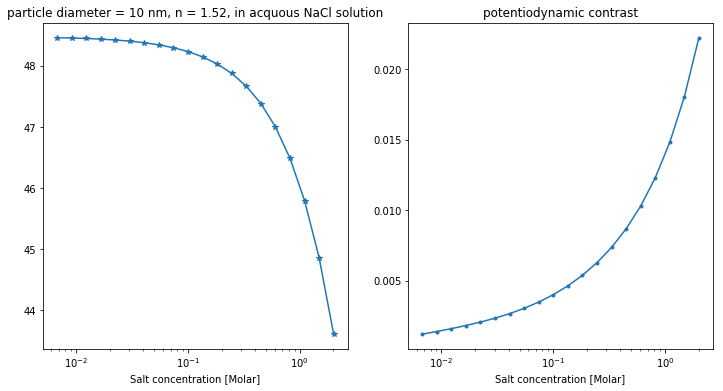

In [33]:
salt_range = np.exp(np.arange(-5.,1.,0.3)) #salt concentrations in Molar
contrast = 0 * salt_range
a_range = 0 * salt_range
for i in np.arange(np.size(salt_range)):
    salinity = salt_range[i]
    ldebye = 0.304/np.sqrt(salinity) 
    x_salt = salinity / 55.39 
    psi[i_obj:] = zeta * r_obj / raxis[i_obj:] * np.exp(-(raxis[i_obj:]-r_obj)/ldebye)
    x_ion[i_obj:] = x_salt * np.exp(psi[i_obj:])
    x_cou[i_obj:] = x_salt * np.exp(-psi[i_obj:])
    n_mix = 1 + K_salt / n_sol * (a_ion * x_ion + a_cou * x_cou)/(a_ion + a_cou) 
    n_mix[:i_obj] = n_obj / n_sol
    n_mix = n_mix / n_mix[-1]
    a_pure = (4 * np.pi / 3) * r_obj**3 * (n_mix[0]**2 - 1)/(n_mix[0]**2 + 2) 
    a_range[i] = a_pure
    integrand = 4 * np.pi * raxis**2 * 0.1 * (n_mix**2 - 1)/(n_mix**2 + 2) 
    contrast[i] = np.sum(integrand[i_obj:])/a_pure
    
# plotting some of the calculated values
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax1.semilogx(salt_range, a_range, '*-')
plt.title("particle diameter = 10 nm, n = 1.52, in acquous NaCl solution")
plt.xlabel("Change is Lorentz factor (~ polarizability)")
plt.xlabel("Salt concentration [Molar]")

ax2 = plt.subplot(122)
ax2.semilogx(salt_range, contrast, '.-')

plt.title("potentiodynamic contrast")
plt.xlabel("Relative change of polarizability)")
plt.xlabel("Salt concentration [Molar]")

plt.show
fig.savefig("polarizability_change.png")